In [102]:
import numpy as np
import mnist
from tensorflow import keras
from keras import datasets
import matplotlib.pyplot as plt

In [103]:
# 卷积层类
class ConvolutionLayer:
  # input : (卷积核数量，卷积核长度，卷积核宽度，单次平移距离，优化器)
  def __init__(self, num_filters, conv_length = 3, conv_width = 3, conv_stride = 1, optimizar = "SGD"):
    self.num_filters = num_filters
    self.length = conv_length
    self.width = conv_width
    self.stride = conv_stride
    self.optimizar = optimizar

    # 卷积核权重参数初始化
    self.filters = np.random.randn(num_filters, self.length, self.width) / (self.length * self.width)

    # 使用动量的随机梯度下降(SGD-M)
    if optimizar == "MomentSGD":
      # 速度
      self.momentum = np.zeros(self.filters.shape)
      # 动量参数alpha
      self.moment_para = 0.5

    # AdaGrad算法
    elif optimizar == "AdaGrad":
      # 累计平方梯度
      self.cumulative_squard = np.zeros(self.filters.shape)
      # 设置小常数，用以被小数除时的数值稳定
      self.small_constant = 1e-7

    # RMSProp算法
    elif optimizar == "RMSProp":
      # 累计移动平均平方梯度
      self.cumulative_squard = np.zeros(self.filters.shape)
      # 设置衰减速率
      self.delay_rate = 0.9
      # 设置小常数，用以被小数除时的数值稳定
      self.small_constant = 1e-6

    # Adam自适应学习率算法
    elif optimizar == "Adam":
      # 有偏一阶矩估计
      self.first_order_moment = np.zeros(self.filters.shape)
      # 有偏二阶矩估计
      self.second_order_moment = np.zeros(self.filters.shape)
      # 一阶矩的指数衰减率
      self.delay_rate_I = 0.9
      # 二阶矩的指数衰减率
      self.delay_rate_II = 0.999
      # 用以数值稳定的小常数
      self.small_constant = 1e-8

  # 迭代分区
  def iterate_regions(self, image):
    h, w = image.shape
    for i in range(h - 2):
      for j in range(w - 2):
        im_region = image[i:(i + 3), j:(j + 3)]
        yield im_region, i, j

  # 前向传播
  # input：(m*n二维数组(手写数字图片))
  # return：三维数组(各个卷积核卷积后得到结果)
  def forward(self, input):
    self.last_input = input
    h, w = input.shape
    output = np.zeros((h - 2, w - 2, self.num_filters))

    for im_region, i, j in self.iterate_regions(input):
      output[i, j] = np.sum(im_region * self.filters, axis=(1, 2))

    # 对卷积层输出应用ReLU激活函数
    output = np.maximum(output, 0)

    return output

  # 反向传播
  def backprop(self, d_L_d_out, learn_rate = 0.01):
    d_L_d_filters = np.zeros(self.filters.shape)
    for im_region, i, j in self.iterate_regions(self.last_input):
      for f in range(self.num_filters):
        d_L_d_filters[f] += d_L_d_out[i, j, f] * im_region

    # 梯度下降
    if self.optimizar == "SGD":
      # 更新梯度
      self.filters -= learn_rate * d_L_d_filters
      
    elif self.optimizar == "MomentSGD":
      # 更新动量
      self.momentum = self.moment_para * self.momentum - learn_rate * d_L_d_filters
      # 更新梯度
      self.filters += self.momentum
      
    elif self.optimizar == "AdaGrad":
      # 更新累计平方梯度
      self.cumulative_squard = self.cumulative_squard + d_L_d_filters * d_L_d_filters
      # 更新梯度
      self.filters -= learn_rate / (np.sqrt(np.maximum(self.cumulative_squard, 0)) + self.small_constant) * d_L_d_filters

    elif self.optimizar == "RMSProp":
      # 更新累计平方梯度
      self.cumulative_squard = self.delay_rate * self.cumulative_squard + (1 - self.delay_rate) * d_L_d_filters * d_L_d_filters
      # 更新梯度
      self.filters -= learn_rate / (np.sqrt(np.maximum(self.cumulative_squard + self.small_constant, 0))) * d_L_d_filters
      
    elif self.optimizar == "Adam":
      # 更新一阶矩
      self.first_order_moment = self.delay_rate_I * self.first_order_moment + (1 - self.delay_rate_I) * d_L_d_filters
      # 更新二阶矩
      self.second_order_moment = self.delay_rate_II * self.second_order_moment + (1 - self.delay_rate_II) * d_L_d_filters * d_L_d_filters
      # 更新梯度
      self.filters -= learn_rate * self.first_order_moment / (np.sqrt(np.maximum(self.second_order_moment, 0)) + self.small_constant)
    return None

In [104]:
class MaxPooling:
  # 池化层：最大池化
  # input：(最大池化层数量， 池化层长度， 池化层宽度，单步平移距离)
  def __init__(self, num_filters, pool_length = 2, pool_width = 2, pool_stride = 2):
    self.num_filters = num_filters
    self.length = pool_length
    self.width = pool_width
    self.stride = pool_stride

  # 生成器函数：遍历输入图片的所有非重叠区域并逐个切片返回
  def iterate_regions(self, image):
    h, w, _ = image.shape
    new_h = h // self.stride
    new_w = w // self.stride

    for i in range(new_h):
      for j in range(new_w):
        im_region = image[(i * self.stride):(i * self.stride + self.length), (j * self.stride):(j * self.stride + self.width)]
        yield im_region, i, j

  # 前向传播函数
  def forward(self, input):
    self.last_input = input

    h, w, num_filters = input.shape
    output = np.zeros((h // self.stride, w // self.stride, num_filters))

    for im_region, i, j in self.iterate_regions(input):
      output[i, j] = np.amax(im_region, axis=(0, 1))

    return output

  # 反向传播函数
  def backprop(self, d_L_d_out):
    d_L_d_input = np.zeros(self.last_input.shape)

    for im_region, i, j in self.iterate_regions(self.last_input):
      h, w, f = im_region.shape
      amax = np.amax(im_region, axis=(0, 1))

      for i2 in range(h):
        for j2 in range(w):
          for f2 in range(f):
            if im_region[i2, j2, f2] == amax[f2]:
              d_L_d_input[i * self.stride + i2, j * self.stride + j2, f2] = d_L_d_out[i, j, f2]

    return d_L_d_input

In [105]:
class Softmax:
  # 全连接层：使用Softmax作为激活函数
  # input: (输入长度, 输出长度/Soft激活函数数量, 优化器)
  def __init__(self, input_len, nodes, optimizar = "SGD"):
    # 权重：W_ij:从池化i到全连接j的权重
    self.weights = np.random.randn(input_len, nodes) / input_len
    # 偏置：w^Tx+b
    self.biases = np.zeros(nodes)
    # 默认使用SGD随机梯度下降
    self.optimizar = optimizar

    # 梯度下降(参数初始化)
    # 带动量的随机梯度下降
    if optimizar == "MomentSGD":
      # 速度项
      self.momentum_w = np.zeros(self.weights.shape)
      self.momentum_b = np.zeros(self.biases.shape)
      # 动量参数
      self.moment_para = 0.5

    # 自适应学习率的梯度下降
    elif optimizar == "AdaGrad":
      self.cumulative_squard_w = np.zeros(self.weights.shape)
      self.cumulative_squard_b = np.zeros(self.biases.shape)
      self.small_constant = 1e-7

    # 均方根传播梯度下降
    elif optimizar == "RMSProp":
      self.cumulative_squard_w = np.zeros(self.weights.shape)
      self.cumulative_squard_b = np.zeros(self.biases.shape)
      self.delay_rate = 0.9
      self.small_constant = 1e-6
      
    # 自适应矩估计梯度下降
    elif optimizar == "Adam":
      self.first_order_moment_w = np.zeros(self.weights.shape)
      self.second_order_moment_w = np.zeros(self.weights.shape)
      self.first_order_moment_b = np.zeros(self.biases.shape)
      self.second_order_moment_b = np.zeros(self.biases.shape)
      self.delay_rate_I = 0.9
      self.delay_rate_II = 0.999
      self.small_constant = 1e-8
      
  # 前向传播函数
  # input : 输入上一层的输出
  def forward(self, input):
    self.last_input_shape = input.shape

    # 二维数据展平为一维
    input = input.flatten()
    self.last_input = input
    # z = w^Tx+b
    totals = np.dot(input, self.weights) + self.biases
    self.last_totals = totals
    # e^z
    exp = np.exp(totals)

    # 返回每一项的概率
    return exp / np.sum(exp, axis=0)

  # 反向传播
  # input: (Loss对输出求导，学习率)
  def backprop(self, d_L_d_out, learn_rate):
    # We know only 1 element of d_L_d_out will be nonzero
    for i, gradient in enumerate(d_L_d_out):
      if gradient == 0:
        continue

      # e^totals
      t_exp = np.exp(self.last_totals)

      # 计算分母：Sum of all e^totals
      S = np.sum(t_exp)

      # 梯度计算：Gradients of out[i] against totals
      d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
      d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)

      # 梯度计算：Gradients of totals against weights/biases/input
      d_t_d_w = self.last_input
      d_t_d_b = 1
      d_t_d_inputs = self.weights

      # 梯度计算：Gradients of loss against totals
      d_L_d_t = gradient * d_out_d_t

      # 梯度计算：Gradients of loss against weights/biases/input
      d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
      d_L_d_b = d_L_d_t * d_t_d_b
      d_L_d_inputs = d_t_d_inputs @ d_L_d_t

      # 更新参数(权重/偏置 weights / biases)
      if self.optimizar == "SGD":        
        self.weights -= learn_rate * d_L_d_w
        self.biases -= learn_rate * d_L_d_b

      elif self.optimizar == "MomentSGD":
        # 更新速度
        self.momentum_w = self.moment_para * self.momentum_w - learn_rate * d_L_d_w
        self.momentum_b = self.moment_para * self.momentum_b - learn_rate * d_L_d_b
        # 更新梯度
        self.weights += self.momentum_w
        self.biases += self.momentum_b

      elif self.optimizar == "AdaGrad":
        # 更新权重
        # 计算"weights"累计平方梯度
        self.cumulative_squard_w = self.cumulative_squard_w + d_L_d_w * d_L_d_w
        self.weights -= learn_rate / (self.small_constant + np.sqrt(np.maximum(self.cumulative_squard_w, 0))) * d_L_d_w
        # 更新偏置
        # 计算"biases"累计平方梯度
        self.cumulative_squard_b = self.cumulative_squard_b + d_L_d_b * d_L_d_b
        self.biases -= learn_rate / (np.sqrt(np.maximum(self.cumulative_squard_b, 0)) + self.small_constant) * d_L_d_b

      elif self.optimizar == "RMSProp":
        # 更新权重
        # 计算"weights"累计平方梯度
        self.cumulative_squard_w = self.delay_rate * self.cumulative_squard_w + (1 - self.delay_rate) * d_L_d_w * d_L_d_w
        self.weights -= learn_rate / (np.sqrt(np.maximum(self.small_constant + self.cumulative_squard_w, 0))) * d_L_d_w
        # 更新偏置
        # 计算"biases"累计平方梯度
        self.cumulative_squard_b = self.delay_rate * self.cumulative_squard_b + (1 - self.delay_rate) * d_L_d_b * d_L_d_b
        self.weights -= learn_rate / (np.sqrt(np.maximum(self.small_constant + self.cumulative_squard_b, 0))) * d_L_d_b
        
      elif self.optimizar == "Adam":
        # 更新权重
        self.first_order_moment_w = self.delay_rate_I * self.first_order_moment_w + (1 - self.delay_rate_I) * d_L_d_w
        self.second_order_moment_w = self.delay_rate_II * self.second_order_moment_w + (1 - self.delay_rate_II) * d_L_d_w * d_L_d_w
        self.weights -= learn_rate * self.first_order_moment_w / (np.sqrt(np.maximum(self.second_order_moment_w, 0)) + self.small_constant)
        # 更新偏置
        self.first_order_moment_b = self.delay_rate_I * self.first_order_moment_b + (1 - self.delay_rate_I) * d_L_d_b
        self.second_order_moment_b = self.delay_rate_II * self.second_order_moment_b + (1 - self.delay_rate_II) * d_L_d_b * d_L_d_b
        self.biases -= learn_rate * self.first_order_moment_b / (np.sqrt(np.maximum(self.second_order_moment_b, 0)) + self.small_constant)

      return d_L_d_inputs.reshape(self.last_input_shape)

In [127]:
x_train = mnist.train_images()[:6000].astype('float32') / 255.0
y_train = mnist.train_labels()[:6000]
x_test = mnist.test_images()[:1000].astype('float32') / 255.0
y_test = mnist.test_labels()[:1000]

In [150]:
class CNN:
    def __init__(self, optimizar = "SGD", learning_rate = 0.01, 
                 conv = ConvolutionLayer(8,3,3,1,"SGD"), 
                 pool = MaxPooling(8,2,2,2), 
                 softmax = Softmax(13*13*8, 10,"SGD")):
        self.optimizar = optimizar
        self.learning_rate = learning_rate
        self.conv = conv
        self.pool = pool
        self.softmax = softmax

    def forward(self, image, label):
        # 数据归一化
        out = self.conv.forward(image)
        out = self.pool.forward(out)
        out = self.softmax.forward(out)

        # Calculate cross-entropy loss and accuracy. np.log() is the natural log.
        loss = -np.log(out[label])
        acc = 1 if np.argmax(out) == label else 0
        return out, loss, acc
    
    def train(self, im, label, lr = 0.001):
        # Forward
        out, loss, acc = self.forward(im, label)

        # Calculate initial gradient
        gradient = np.zeros(10)
        gradient[label] = -1 / out[label]

        # Backprop
        gradient = self.softmax.backprop(gradient, lr)
        gradient = self.pool.backprop(gradient)
        gradient = self.conv.backprop(gradient, lr)

        return loss, acc
    
    def fit(self, x_train, y_train, num_epoch=10, batch_size = 32):
        accuracy = []
        for epoch in range(num_epoch):
          print('--- Epoch %d ---' % (epoch + 1))

          # Shuffle the training data
          permutation = np.random.permutation(len(x_train))
          x_train = x_train[permutation]
          y_train = y_train[permutation]

          # Train!
          loss = 0
          num_correct = 0
          for i, (im, label) in enumerate(zip(x_train, y_train)):
            if i % batch_size == batch_size-1:
              print('[Step %d] Past %d steps: Average Loss %.4f | Accuracy: %.4f' % (i + 1, batch_size, loss / batch_size, num_correct/(batch_size)))
              loss = 0
              accuracy.append(num_correct/(batch_size))
              num_correct = 0

            l, acc = self.train(im, label)
            loss += l
            num_correct += acc
        return accuracy

MNIST CNN initialized!
--- Epoch 1 ---
[Step 100] Past 100 steps: Average Loss 2.2591 | Accuracy: 0.1700
[Step 200] Past 100 steps: Average Loss 2.2426 | Accuracy: 0.3800
[Step 300] Past 100 steps: Average Loss 2.2087 | Accuracy: 0.3400
[Step 400] Past 100 steps: Average Loss 2.1458 | Accuracy: 0.5500
[Step 500] Past 100 steps: Average Loss 2.1514 | Accuracy: 0.4000
[Step 600] Past 100 steps: Average Loss 2.0493 | Accuracy: 0.5300
[Step 700] Past 100 steps: Average Loss 2.0690 | Accuracy: 0.5100
[Step 800] Past 100 steps: Average Loss 1.9656 | Accuracy: 0.6200
[Step 900] Past 100 steps: Average Loss 1.8885 | Accuracy: 0.6500
[Step 1000] Past 100 steps: Average Loss 1.7586 | Accuracy: 0.7100
[Step 1100] Past 100 steps: Average Loss 1.6922 | Accuracy: 0.7500
[Step 1200] Past 100 steps: Average Loss 1.6280 | Accuracy: 0.7200
[Step 1300] Past 100 steps: Average Loss 1.5022 | Accuracy: 0.7500
[Step 1400] Past 100 steps: Average Loss 1.3789 | Accuracy: 0.7500
[Step 1500] Past 100 steps: Aver

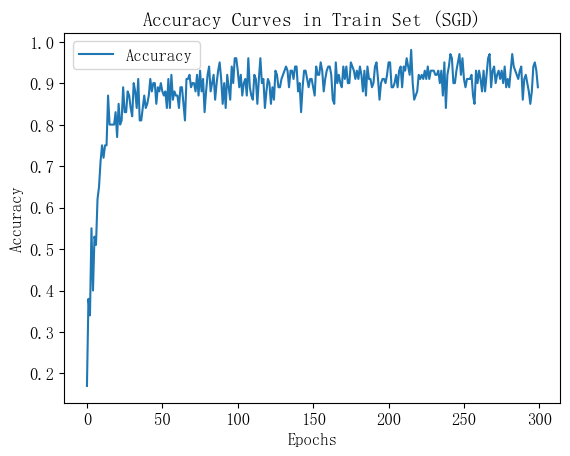

In [151]:
# Epochs（迭代次数）和batch size（批量大小）
print('MNIST CNN initialized!')
# np.random.seed(42)
# 28 * 28 --> 26 * 26 --> 13 * 13 --> 10
network0 = CNN(conv = ConvolutionLayer(32,3,3,1,"SGD"), pool = MaxPooling(32,2,2,2), softmax = Softmax(13*13*32, 10,"SGD"))
accuracy0 = network0.fit(x_train, y_train, num_epoch=5, batch_size=100)

# 绘制准确度曲线
plt.plot(accuracy0, label='Accuracy')
plt.title('Accuracy Curves in Train Set (SGD)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [128]:
# Epochs（迭代次数）和batch size（批量大小）
print('MNIST CNN initialized!')
np.random.seed(42)
# 28 * 28 --> 26 * 26 --> 13 * 13 --> 10
network1 = CNN(conv = ConvolutionLayer(32,3,3,1,"MomentSGD"), pool = MaxPooling(32,2,2,2), softmax = Softmax(13*13*32, 10,"MomentSGD"))
accuracy1 = network1.fit(x_train, y_train, num_epoch=5, batch_size=100)
# 31m 55.4s

MNIST CNN initialized!
--- Epoch 1 ---
[Step 100] Past 100 steps: Average Loss 2.2001 | Accuracy: 0.2700
[Step 200] Past 100 steps: Average Loss 2.0224 | Accuracy: 0.5400
[Step 300] Past 100 steps: Average Loss 1.8908 | Accuracy: 0.5100
[Step 400] Past 100 steps: Average Loss 1.6971 | Accuracy: 0.5700
[Step 500] Past 100 steps: Average Loss 1.5065 | Accuracy: 0.6000
[Step 600] Past 100 steps: Average Loss 1.3892 | Accuracy: 0.6800
[Step 700] Past 100 steps: Average Loss 1.0716 | Accuracy: 0.8000
[Step 800] Past 100 steps: Average Loss 1.0804 | Accuracy: 0.7100
[Step 900] Past 100 steps: Average Loss 0.8218 | Accuracy: 0.7800
[Step 1000] Past 100 steps: Average Loss 0.7507 | Accuracy: 0.8200
[Step 1100] Past 100 steps: Average Loss 0.7647 | Accuracy: 0.8100
[Step 1200] Past 100 steps: Average Loss 0.6899 | Accuracy: 0.8200
[Step 1300] Past 100 steps: Average Loss 0.5556 | Accuracy: 0.8500
[Step 1400] Past 100 steps: Average Loss 0.6467 | Accuracy: 0.8300
[Step 1500] Past 100 steps: Aver

In [129]:
# Epochs（迭代次数）和batch size（批量大小）
print('MNIST CNN initialized!')
np.random.seed(42)
# 28 * 28 --> 26 * 26 --> 13 * 13 --> 10
network2 = CNN(conv = ConvolutionLayer(32,3,3,1,"AdaGrad"), pool = MaxPooling(32,2,2,2), softmax = Softmax(13*13*32, 10,"AdaGrad"))
accuracy2 = network2.fit(x_train, y_train, num_epoch=5, batch_size=100)
# 12m 21.0s

MNIST CNN initialized!
--- Epoch 1 ---
[Step 100] Past 100 steps: Average Loss 2.1725 | Accuracy: 0.3100
[Step 200] Past 100 steps: Average Loss 1.9676 | Accuracy: 0.5200
[Step 300] Past 100 steps: Average Loss 1.8750 | Accuracy: 0.4900
[Step 400] Past 100 steps: Average Loss 1.7553 | Accuracy: 0.6200
[Step 500] Past 100 steps: Average Loss 1.6467 | Accuracy: 0.6200
[Step 600] Past 100 steps: Average Loss 1.6476 | Accuracy: 0.6300
[Step 700] Past 100 steps: Average Loss 1.4863 | Accuracy: 0.8000
[Step 800] Past 100 steps: Average Loss 1.4978 | Accuracy: 0.6500
[Step 900] Past 100 steps: Average Loss 1.3370 | Accuracy: 0.7900
[Step 1000] Past 100 steps: Average Loss 1.3019 | Accuracy: 0.7500
[Step 1100] Past 100 steps: Average Loss 1.2987 | Accuracy: 0.7600
[Step 1200] Past 100 steps: Average Loss 1.2298 | Accuracy: 0.7800
[Step 1300] Past 100 steps: Average Loss 1.0993 | Accuracy: 0.8000
[Step 1400] Past 100 steps: Average Loss 1.1143 | Accuracy: 0.7800
[Step 1500] Past 100 steps: Aver

In [130]:
# Epochs（迭代次数）和batch size（批量大小）
print('MNIST CNN initialized!')
np.random.seed(42)
# 28 * 28 --> 26 * 26 --> 13 * 13 --> 10
network3 = CNN(conv = ConvolutionLayer(32,3,3,1,"RMSProp"), pool = MaxPooling(32,2,2,2), softmax = Softmax(13*13*32, 10,"RMSProp"))
accuracy3 = network3.fit(x_train, y_train, num_epoch=5, batch_size=100)
# 22m 1.7s

MNIST CNN initialized!
--- Epoch 1 ---
[Step 100] Past 100 steps: Average Loss 2.2478 | Accuracy: 0.2800
[Step 200] Past 100 steps: Average Loss 1.5044 | Accuracy: 0.5900
[Step 300] Past 100 steps: Average Loss 1.2906 | Accuracy: 0.5900
[Step 400] Past 100 steps: Average Loss 0.8866 | Accuracy: 0.7400
[Step 500] Past 100 steps: Average Loss 0.8496 | Accuracy: 0.6700
[Step 600] Past 100 steps: Average Loss 0.8250 | Accuracy: 0.7200
[Step 700] Past 100 steps: Average Loss 0.5313 | Accuracy: 0.8300
[Step 800] Past 100 steps: Average Loss 0.8368 | Accuracy: 0.7500
[Step 900] Past 100 steps: Average Loss 0.4687 | Accuracy: 0.8900
[Step 1000] Past 100 steps: Average Loss 0.5268 | Accuracy: 0.8200
[Step 1100] Past 100 steps: Average Loss 0.5628 | Accuracy: 0.8200
[Step 1200] Past 100 steps: Average Loss 0.5501 | Accuracy: 0.8000
[Step 1300] Past 100 steps: Average Loss 0.4611 | Accuracy: 0.8600
[Step 1400] Past 100 steps: Average Loss 0.5798 | Accuracy: 0.8300
[Step 1500] Past 100 steps: Aver

In [131]:
# Epochs（迭代次数）和batch size（批量大小）
print('MNIST CNN initialized!')
np.random.seed(42)
# 28 * 28 --> 26 * 26 --> 13 * 13 --> 10
network4 = CNN(conv = ConvolutionLayer(32,3,3,1,"Adam"), pool = MaxPooling(32,2,2,2), softmax = Softmax(13*13*32, 10,"Adam"))
accuracy4 = network4.fit(x_train, y_train, num_epoch=5, batch_size=100)
# 22m 43.5s

MNIST CNN initialized!
--- Epoch 1 ---
[Step 100] Past 100 steps: Average Loss 2.1466 | Accuracy: 0.4500
[Step 200] Past 100 steps: Average Loss 1.3610 | Accuracy: 0.7000
[Step 300] Past 100 steps: Average Loss 1.0631 | Accuracy: 0.6500
[Step 400] Past 100 steps: Average Loss 0.6755 | Accuracy: 0.8200
[Step 500] Past 100 steps: Average Loss 0.6459 | Accuracy: 0.7800
[Step 600] Past 100 steps: Average Loss 0.6684 | Accuracy: 0.7600
[Step 700] Past 100 steps: Average Loss 0.4720 | Accuracy: 0.8800
[Step 800] Past 100 steps: Average Loss 0.6936 | Accuracy: 0.8200
[Step 900] Past 100 steps: Average Loss 0.4330 | Accuracy: 0.9000
[Step 1000] Past 100 steps: Average Loss 0.4922 | Accuracy: 0.8500
[Step 1100] Past 100 steps: Average Loss 0.4753 | Accuracy: 0.8800
[Step 1200] Past 100 steps: Average Loss 0.4493 | Accuracy: 0.8700
[Step 1300] Past 100 steps: Average Loss 0.3787 | Accuracy: 0.9000
[Step 1400] Past 100 steps: Average Loss 0.4435 | Accuracy: 0.8500
[Step 1500] Past 100 steps: Aver

In [ ]:
x_train = mnist.train_images()[:6000].astype('float32') / 255.0
y_train = mnist.train_labels()[:6000]
x_test = mnist.test_images()[:1000].astype('float32') / 255.0
y_test = mnist.test_labels()[:1000]
# 创建一个图形对象
fig, ax = plt.subplots(figsize=(12, 6), dpi=1080)
# 创建一个子图对象
axins = ax.inset_axes((0.25, 0.20, 0.50, 0.40))
# 设置颜色
colors = ['y-','b-','c-','r-','g-']
# 优化器方法
optimizers = ["SGD","MomentSGD","AdaGrad","RMSProp","Adam"]
for i in range(5):
    color = colors[i]
    optimizer = optimizers[i]
    np.random.seed(42)
    # 28 * 28 --> 26 * 26 --> 13 * 13 --> 10
    network = CNN(conv = ConvolutionLayer(32,3,3,1,optimizer), pool = MaxPooling(32,2,2,2), softmax = Softmax(13*13*32, 10,optimizer))
    accuracy = network4.fit(x_train, y_train, num_epoch=5, batch_size=100)
    # 绘制准确度曲线
    ax.plot(accuracy, color, label='Accuracy('+optimizer+')')
    axins.plot(accuracy[:30], color, label='Accuracy('+optimizer+')')

# 设置标题、坐标轴标签和图例
ax.set_title('Accuracy Curves in Train Set')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()
# 显示图形
plt.show()

In [152]:
import matplotlib.pyplot as plt

# 创建一个图形对象
fig, ax = plt.subplots(figsize=(12, 6), dpi=1080)

# 绘制准确度曲线
ax.plot(accuracy0, 'y-', label='Accuracy(SGD)')
ax.plot(accuracy1, 'b-', label='Accuracy(SGD-M)')
ax.plot(accuracy2, 'c-', label='Accuracy(AdaGrad)')
ax.plot(accuracy3, 'r-', label='Accuracy(RMSProp)')
ax.plot(accuracy4, 'g-', label='Accuracy(Adam)')

# 创建一个子图对象
axins = ax.inset_axes((0.25, 0.20, 0.50, 0.40))

# 在子图对象上绘制准确度曲线
axins.plot(accuracy0[:30], 'y-', label='Accuracy(SGD)')
axins.plot(accuracy1[:30], 'b-', label='Accuracy(SGD-M)')
axins.plot(accuracy2[:30], 'c-', label='Accuracy(AdaGrad)')
axins.plot(accuracy3[:30], 'r-', label='Accuracy(RMSProp)')
axins.plot(accuracy4[:30], 'g-', label='Accuracy(Adam)')

# 设置标题、坐标轴标签和图例
ax.set_title('Accuracy Curves in Train Set')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()

# 显示图形
plt.show()

In [153]:
# Test the CNN
optimizers = ["SGD","MomentSGD","AdaGrad","RMSProp","Adam"]
networks = [network0, network1, network2, network3, network4]
print('\n--- Testing the CNN ---')
for i in range(5):
  network = networks[i]
  optimizer = optimizers[i]
  loss = 0
  num_correct = 0
  loss_set = []
  for im, label in zip(x_test, y_test):
    _, l, acc = network.forward(im, label)
    loss += l
    num_correct += acc
    loss_set.append(loss)
  num_tests = len(x_test)
  print('Use optimizer:'+optimizer)
  print('Test Loss:', loss / num_tests)
  print('Test Accuracy:', num_correct / num_tests)


--- Testing the CNN ---
Use optimizer:SGD
Test Loss: 0.3400552373374721
Test Accuracy: 0.898
Use optimizer:MomentSGD
Test Loss: 0.40690568575468344
Test Accuracy: 0.874


KeyboardInterrupt: 